# Contexto analítico

Requerimos diseñar un modelo que permita determinar el precio medio de las viviendas en Boston, para ello contamos con un set de información disponible en Keras con características y precios de viviendas en diferentes ubicaciones de Boston de finales de 1970. (Mayor detalle disponible en http://lib.stat.cmu.edu/datasets/boston 

En total contamos con 506 muestras caracterizadas por 13 variables:


Variables | Description
 --- | ---
 CRIM   |  per capita crime rate by town
 ZN     |  proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS  |  proportion of non-retail business acres per town
 CHAS   |  Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX    |  nitric oxides concentration (parts per 10 million)
 RM     |  average number of rooms per dwelling
 AGE    |  proportion of owner-occupied units built prior to 1940
 DIS    |  weighted distances to five Boston employment centres
 RAD    |  index of accessibility to radial highways
 TAX    |  full-value property-tax rate per \$10,000
 PTRATIO|  pupil-teacher ratio by town
 B      |  1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT  |  % lower status of the population
 MEDV   |  Median value of owner-occupied homes in $1000's

In [ ]:
# Division de datos de entrenamiento y prueba

from keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=0.2,seed=10)

In [ ]:
print("Tamaño set de entrenamiento:",x_train.shape)
print("Tamaño set de prueba:",x_test.shape)

Tamaño set de entrenamiento: (404, 13)
Tamaño set de prueba: (102, 13)


# Arquitectura propuesta

Para diseñar el modelo implementaremos un red secuencial tal y como se *ilustra* enseguida:

![Arquitectura1](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F53b8ede5-d496-4609-b3f4-621a540e0259%2FUntitled.png?table=block&id=9378bee8-4515-40bd-a12c-8de02812323d&width=1960&userId=5d54f20c-b387-4e7e-b2a5-d88e235ada88&cache=v2)


Donde:
- La primera capa de entrada tiene 13 neuronas (igual al número de variables del dataset),

- La primera capa oculta tiene 6 neuronas,

- La seguda capa oculta tiene 4 neuronas,

- La capa de salida tiene una neurona y es la que entrega el valor de los precios. 

Debido a que se cuenta con un dataset de 13 variables, es posible que existan entre ellas complejidades no lineales. Por lo tanto, se escoge utilzar inicialmente 2 capas ocultas para identificar estas relaciones a través de las funciones de activación ReLU. 

El número de neuronas por capa fue escogido siguiendo la regla empírica en el que se escoge la potencia de 2 más cercana a 2$\cdot$(número de entradas). Asimismo se implementan capas de tipo **Dense**, en donde todas las neuronas están conectadas a las neuronas de la siguiente capa.

Otro aspecto a considerar son los pesos con los que inicia la red. Una estrategia que ha demostrado tener buen desempeño es la estrategia Glorot / Xavier, en donde se toman en cuenta los parámetros de entrada y los parámetros de salida de cada neurona.  En las capas de tipo Dense la inicialización por defecto es **Glorot-Uniforme**. 

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
#Definición de la arquitectura
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal',activation='relu'))
model.add(Dense(6, kernel_initializer='normal',activation='relu'))
model.add(Dense(4, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))


Para medir el desempeño del algoritmo necesitamos utilizar funciones de costo, las cuales calculan la distancia entre la salida actual del algoritmo y la salida esperada. Es decir, en cada iteración se producirá un valor de predicción que se comparará con el valor real. 

La métrica que se usará para medir ese cambio será la '`mean_squared_error`' (o el valor cuadrático medio), el cual penaliza el modelo cuando existen grandes errores debido a que contiene términos cuadráticos en su [definición](https://www.notion.so/mariajosemv/Redes-neuronales-en-Keras-y-ScikitLearn-b8fcf479b0464021bb85d1b2a8863404#a2eede18a18f4861a7a3da90c89606bb).

Una vez conocida esta diferencia o error, el objetivo principal de la red es tratar de minimizarlo. Para ello, se implementa el optimizador **[ADAM](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/)**, que combina los métodos de AdaGrad y Momentum. 



In [ ]:
# Compilación del modelo
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_percentage_error'])

In [ ]:
# Visualizacion del modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________
None


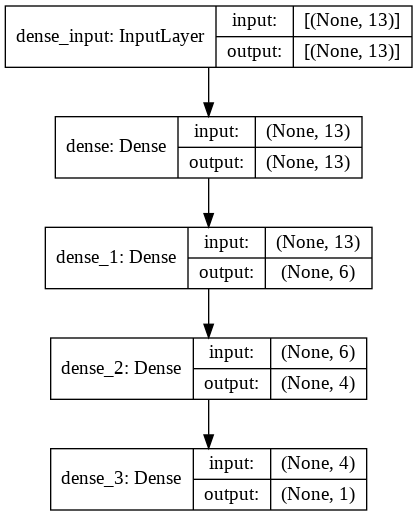

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)
#plot_model(model, to_file='model.png',show_shapes=True)

# Entrenamiento y Evaluación

Ahora realizaremos diferentes entrenamientos de la red neuronal diseñada y evaluaremos su desempeño, pero antes es importante aclarar que además de hacer la división en datos de entrenamiento y datos de prueba, se debe hacer una division adicional conocida como **validación**. 

Con la validación el algoritmo va a ir tomando una proporción de datos recurrentemente para hacer evaluaciones con las métricas de desempeño. Los datos de validación se toman de los datos de entrenamiento.

Una vez separados los datos, para el entrenamiento del modelo se debe tener en cuenta los siguientes parámetros: 

- `batch_size`: tamaño de la muestra con que la red irá entrenando. A medida que este número aumente, el tiempo de ejecución también lo hará. 

- `epochs`: cantidad de iteraciones del algoritmo.

Inicialmente el modelo se entrenará 5 veces con 32 muestras en cada iteración. 


In [ ]:
# Set de validación
x_val = x_train[300:,]
y_val = y_train[300:,]

#Entrena el modelo
model.fit(x_train, y_train, batch_size=32, epochs=5,validation_data=(x_val,y_val))

Epoch 1/5
13/13 [==============================] - 1s 35ms/step - loss: 592.8109 - mean_absolute_percentage_error: 99.9746 - val_loss: 536.2390 - val_mean_absolute_percentage_error: 99.8699
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 607.3911 - mean_absolute_percentage_error: 99.8126 - val_loss: 533.5818 - val_mean_absolute_percentage_error: 99.4994
Epoch 3/5
13/13 [==============================] - 0s 4ms/step - loss: 595.4907 - mean_absolute_percentage_error: 99.2877 - val_loss: 524.4310 - val_mean_absolute_percentage_error: 98.1925
Epoch 4/5
13/13 [==============================] - 0s 4ms/step - loss: 584.9845 - mean_absolute_percentage_error: 97.5724 - val_loss: 498.4420 - val_mean_absolute_percentage_error: 94.4218
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 517.0470 - mean_absolute_percentage_error: 92.8146 - val_loss: 437.3676 - val_mean_absolute_percentage_error: 84.9598


Resultados: 

- loss: 517.0470
- mean_absolute_percentage_error: 92.8146
- val_loss: 437.3676
- val_mean_absolute_percentage_error: 84.9598

Esto indica que la arquitectura o la forma de entrenamiento del modelo no es eficiente.

Se aumentará el número de epochs.

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=100,validation_data=(x_val,y_val))

Epoch 1/100
13/13 [==============================] - 0s 7ms/step - loss: 434.6814 - mean_absolute_percentage_error: 78.4928 - val_loss: 322.8848 - val_mean_absolute_percentage_error: 66.2538
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 292.9273 - mean_absolute_percentage_error: 58.1620 - val_loss: 179.4772 - val_mean_absolute_percentage_error: 45.7815
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 166.9424 - mean_absolute_percentage_error: 48.0968 - val_loss: 132.5123 - val_mean_absolute_percentage_error: 51.7221
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 141.2339 - mean_absolute_percentage_error: 52.6816 - val_loss: 132.7404 - val_mean_absolute_percentage_error: 53.8683
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 132.0986 - mean_absolute_percentage_error: 49.1775 - val_loss: 119.1605 - val_mean_absolute_percentage_error: 46.6985
Epoch 6/100
13/13 [==========================

Resultados: 

- loss: 40.6419
- mean_absolute_percentage_error: 20.9611
- val_loss: 39.9811
- val_mean_absolute_percentage_error: 25.4993

En esta ocasión sí se obtuvieron resultados más satisfactorios ya que al aumentar el número de iteraciones (epochs), el algoritmo modifica los pesos de tal forma que pueda ajustarse adecuadamente a los datos. 

Finalmente, evaluemos el desempeño real del algoritmo con los datos de prueba:

In [ ]:
result = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 34.9000 - mean_absolute_percentage_error: 18.8895


In [ ]:
print(f"Loss: {result[0]}, mean_absolute_percentage_error: {result[1]}")

Loss: 34.900028228759766, mean_absolute_percentage_error: 18.889509201049805


Esto nos indica que el desempeño tanto con los datos de entrenamiento como con los datos de prueba es similar y se considera aceptable. 

# Visualizando el proceso de entrenamiento

En la sección anterior se mostró como puede mejorar el modelo al aumentar el número de iteraciones (epochs), esto abre la posibilidad de que el modelo actual pueda seguir mejorando, e incluso, encontrar un valor a partir del cual se encuentre el mejor desempeño. Para tal fin, se representará visualmente la evolución del modelo. 



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=200,validation_data=(x_val,y_val), verbose=0)

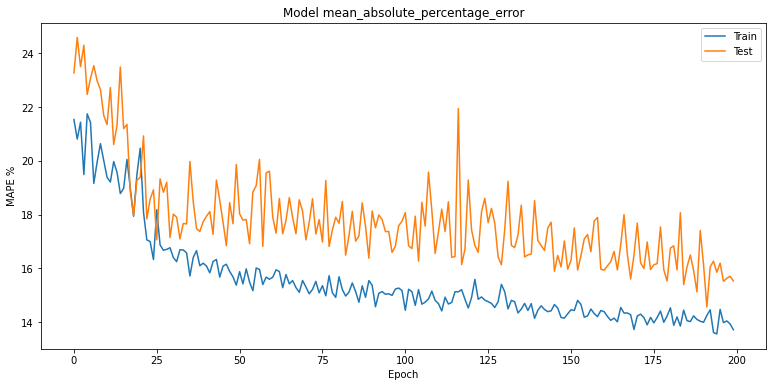

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,6))
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Model mean_absolute_percentage_error')
plt.ylabel('MAPE %')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


Esta gráfica nos dice da dos características importantes sobre el modelo:

1. El modelo evoluciona hacia la dirección correcta ya que se tiene una disminución en el error porcentual a medida que aumenta el número de iteraciones. 

2. A partir de la iteración 125, el error porcentual empieza a disminuir ligeramente. Esto quiere decir que a pesar de que se aumente el número de iteraciones, la mejora en el desempeño del modelo no es muy apreciable.

A continuación evaluemos la función de pérdida del modelo.


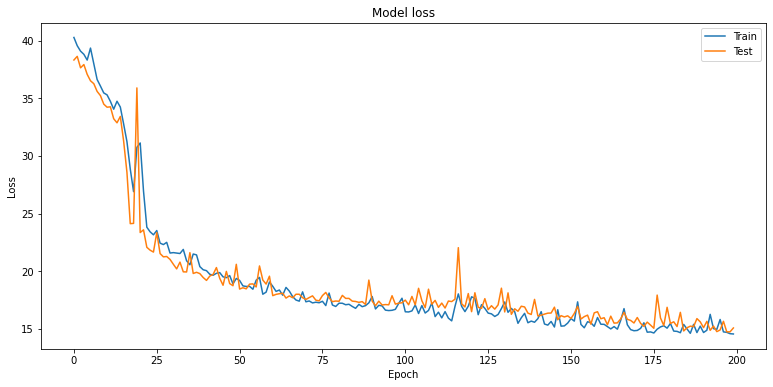

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Esta gŕafica de igual manera pone de manifiesto el ajuste del modelo de acuerdo a los datos. A partir de la iteración 125 las mejoras fueron relativamente pequeñas. La importancia en este plot es identificar que no existe una gran diferencia entre el set de validación y el set de entrenamiento. 